In [0]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.utils.data as Data
import torchvision
import pickle

from torch.autograd import Variable
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score

%matplotlib inline
np.random.seed(0)

In [0]:
from google.colab import drive
drive.mount('/content/data')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/data


In [0]:
os.chdir('/content/data/My Drive/DL_Assignment_2')

In [0]:
Data = pd.read_csv('./Data_2/data.csv',delimiter = ',',header = None)
labels = pd.read_csv('./Data_2/label.csv',delimiter = ',',header = None)

X = np.array(Data.iloc[:, 0:784])
Y = np.array(Data.iloc[:, 784])

#train,test splt
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state=0)

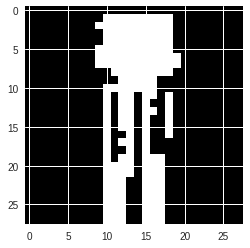

In [0]:
plt.imshow(X[401].reshape(28,28))

In [0]:
#### Auto Encoder  #############

def Flip_Bits(data, percentage):
  noisy_data = data.copy()
  for i in range(data.shape[0]):
    select_pixels = np.random.randint(0,data.shape[1], (int(percentage*data.shape[1])))
    noisy_data[i,select_pixels] = 1 - data[i,select_pixels]
    
  return noisy_data

class ConcatDataset(torch.utils.data.Dataset):
    def __init__(self, *datasets):
        self.datasets = datasets

    def __getitem__(self, i):
        return tuple(d[i] for d in self.datasets)

    def __len__(self):
        return min(len(d) for d in self.datasets)

class AutoEncoder(nn.Module):
    def __init__(self,D_in, NL, L):
        super(AutoEncoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(D_in, NL),
            nn.ReLU(),
            nn.Linear(NL, L),
        )
        self.decoder = nn.Sequential(
            nn.Linear(L, NL),
            nn.ReLU(),
            nn.Linear(NL, D_in),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded
    
      
def DenoisingAE_Model(x_train, x_train_noisy,x_test, x_test_noisy, bottle_neck_size,nonlinear_layer_size):
  
  device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
  torch.set_default_tensor_type('torch.DoubleTensor')
  dtype = torch.int64
  
      
  x_train_torch = torch.tensor(x_train); 
  x_train_torch = x_train_torch.to(device)
  
  x_test_torch = torch.tensor(x_test); 
  x_test_torch = x_test_torch.to(device)
  
  x_train_noisy_torch = torch.tensor(x_train_noisy); 
  x_train_noisy_torch = x_train_noisy_torch.to(device)
  
  x_test_noisy_torch = torch.tensor(x_test_noisy); 
  x_test_noisy_torch = x_test_noisy_torch.to(device)


  D_in = 784
  NL = nonlinear_layer_size
  L = bottle_neck_size
  MAX_EPOCH = 1000
  BATCH_SIZE = 2048
  LR = 1e-4        


  train_loader = torch.utils.data.DataLoader(ConcatDataset(x_train_torch,x_train_noisy_torch), batch_size=BATCH_SIZE, shuffle=False)


  AE = AutoEncoder(D_in, NL, L)
  AE = AE.to(device)
  optimizer = torch.optim.Adam(AE.parameters(), lr=LR)
  loss_fn = torch.nn.BCELoss()
  error_train = []
  for epoch in range(MAX_EPOCH):
      batch_loss = []
      for data in train_loader:  
        
        img, img_noisy = data
        
        img_noisy = img_noisy.double()

        encoded, decoded = AE(img_noisy)
        
        decoded = decoded.double()
        img = img.double()

        loss = loss_fn(decoded, img)

        batch_loss.append(loss.item())
        optimizer.zero_grad()               
        loss.backward()                     
        optimizer.step()  

      mean_batch_loss = np.mean(batch_loss)
      del batch_loss
      if epoch % 50 == 0:
          print(epoch, mean_batch_loss.item())    
      error_train.append(mean_batch_loss.item())

      if  epoch>= 5 and abs(error_train[epoch-1] - error_train[epoch]) <= 1e-5:
        print('Reached threshold')
        break     
  plt.plot(error_train, color = 'g', label = 'Reconstruction error')
  plt.legend()

  plt.xlabel('epochs')
  plt.ylabel('BCE loss')
  plt.title('BCE loss vs epochs')
  
  print('***********************************')
  print('number of epochs:', len(error_train))
  print('training reconstruction error: ', error_train[-1])
   
  x_test_noisy_torch = x_test_noisy_torch.double()
  _ , decoded_test = AE(x_test_noisy_torch)      
  decoded_test = decoded_test.double()
  x_test_torch = x_test_torch.double()
  loss_test = loss_fn(decoded_test, x_test_torch)
  loss_test = loss_test.item()
  print('testing reconstruction error: ', loss_test)
  print('***********************************')
  
  x_train_noisy_torch = x_train_noisy_torch.double()
  x_test_noisy_torch = x_test_noisy_torch.double()
  
  _ , x_train_denoised = AE(x_train_noisy_torch)
  x_train_denoised = x_train_denoised.cpu().detach().numpy()
  x_train_denoised = np.where(x_train_denoised>=0.5,1,0)
  
  _ , x_test_denoised = AE(x_test_noisy_torch)
  x_test_denoised = x_test_denoised.cpu().detach().numpy()
  x_test_denoised = np.where(x_test_denoised>=0.5,1,0)
  
  
  return AE, x_train_denoised, x_test_denoised

0 0.6791736942337989
50 0.17905921830216245
100 0.15663311000954064
150 0.14333951022303698
200 0.13507153712553863
250 0.1292179336815708
300 0.12483452767854121
350 0.12119268811694527
400 0.11835034692383004
450 0.11601425866821737
500 0.11402908862472948
550 0.11236038094120795
600 0.11097972890210109
650 0.10982466685413535
700 0.10884553670678279
750 0.10802736766152968
800 0.1072786332353065
Reached threshold
***********************************
number of epochs: 833
training reconstruction error:  0.10684868055437839
testing reconstruction error:  0.12637497952330862
***********************************


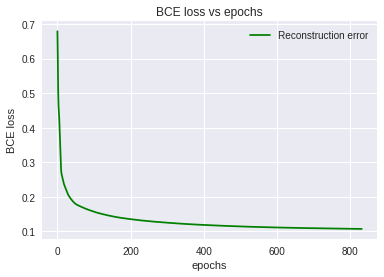

In [0]:
x_train_noisy_20_percenr = Flip_Bits(x_train,0.2)
x_test_noisy_20_percent = Flip_Bits(x_test,0.2)
_ , x_train_denoised, x_test_denoised = DenoisingAE_Model(x_train, x_train_noisy_20_percenr,x_test, x_test_noisy_20_percent, bottle_neck_size = 50 ,nonlinear_layer_size = 500 )

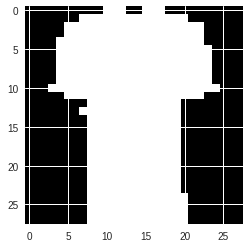

In [0]:
plt.imshow(x_test[4660].reshape(28,28))

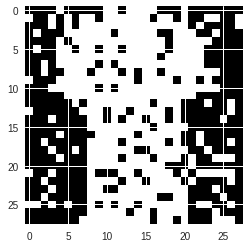

In [0]:
plt.imshow(x_test_noisy_20_percent[4660].reshape(28,28))

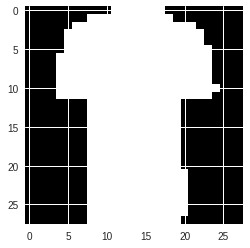

In [0]:
plt.imshow(x_test_denoised[4660].reshape(28,28))

In [0]:
x_train_noisy_30_percenr = Flip_Bits(x_train,0.3)
x_test_noisy_30_percent = Flip_Bits(x_test,0.3)
_ , x_train_denoised2, x_test_denoised2 = DenoisingAE_Model(x_train, x_train_noisy_30_percenr, x_test_noisy_30_percent, bottle_neck_size = 250 ,nonlinear_layer_size = 500 )